# Preliminaries and Imports
In the following cell, the necessary packages and libraries are imported.

In [44]:
# access to different databases
import pandas_datareader as web
import quandl as quandl
import wrds as wrds

# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from tqdm import tqdm
import time

# statistics and regression
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Lasso
from scipy.stats.mstats import winsorize
import quantstats as qs
from scipy.optimize import minimize 
from sklearn import metrics
from scipy import stats

# indicators
import ta as ta
from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.trend import AroonIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from pandas.tseries.offsets import BDay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.axis import Axis
import matplotlib.dates as mdates 
%matplotlib inline

# warning
import warnings
warnings.filterwarnings("ignore")

# unzipping zip-files
from zipfile import ZipFile

# Data Imports and Preperations

In [45]:
# define an useful path
#path = Path('/Users/sebastiansydow/13_Quant_Trading/Group_Project')
path = Path(r'\Users\Strahinja\Desktop\books_Germany\Quant\Group_Project')
# stocks
input_stocks = path / 'permno_selection.csv'
# link betweeen CRSP (permno) and Option Metrics (SECID)
link_permno_secid = path / 'daily_permno_secid_cusip_link.csv.zip'
# glb
glb = path / 'glb_daily.csv'
# model-free implied skewness (MFIS)
mfis = path / 'mfis.csv'
# Save a hdf locally for easier modeling
hdf_path = path / 'factors.h5'
#quandl key
quandl_key = path / 'quandl_key.xlsx'
#quandl_key = 'XWVLTpJSLyiA8s66Fh8x'
# import stocks from S&P 500 into a pandas dataframe
df_input_stocks = pd.read_csv(input_stocks)
# glb
df_glb = pd.read_csv(glb)
## rename column
df_glb = df_glb.rename(columns={"id": "permno"})
## transfrom data type
df_glb['date'] = pd.to_datetime(df_glb['date'])
# mfis
df_mfis = pd.read_csv(mfis)
## rename column
df_mfis = df_mfis.rename(columns={"id": "permno"})
## transfrom data type
df_mfis['date'] = pd.to_datetime(df_mfis['date'])
# instantiate zip-file
zip_file = ZipFile(link_permno_secid)
# load linking table
df_link_permno_secid = pd.read_csv(zip_file.open('daily_permno_secid_cusip_link.csv'))

## Daily Stock Returns, Market Capitalization and Value Weights

In [46]:
def retrieve_stock_data(df_input, date_start, date_end, wrds_username):
    # Download stock data
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # create query to load the returns, prices and shares outstanding for S&P 500 companies from 1999/01
    sql_wrds = """
            select distinct date, 
                            permno,
                            cusip, 
                            ret, 
                            abs(prc) as prc, 
                            shrout,
                            abs(prc)*shrout/1000 as mktval
            from crsp.dsf 
            where permno in %(permno)s and date>=%(start)s and date<=%(end)s
            order by date
            """

    # define the parameters, i.e. only those companies (permno), which were part of the S&P 500
    # in the timeframe 2000/01 until 2020/12
    params = {}
    params['start'] = date_start
    params['end'] = date_end
    params['permno'] = tuple(df_input.permno.unique().astype(str))

    # retrieve the data from wrds
    df_stock_data = db.raw_sql(sql_wrds, params = params)

    # change type of entries in the columns start and ending
    df_stock_data['date']  = pd.to_datetime(df_stock_data['date'])
    
    # shift market_val by 1 day
    df_stock_data.loc[:,'mktval_shifted'] = df_stock_data.groupby(['permno'])['mktval'].shift(1)
    
    # dropna

    
    # calculate weight of each stock on each day
    ## dataframe with total market value on each day
    df_ttl_mkcap = df_stock_data[['date', 'mktval_shifted']].groupby('date').sum().rename(columns={"mktval_shifted": "ttl_mktval"})
    ## merge with df_stock_data
    df_stock_data = pd.merge(df_stock_data, df_ttl_mkcap, how='left', on=['date'])
    ## calculate weightage
    df_stock_data['weightage_pct'] =  df_stock_data['mktval_shifted'] / df_stock_data["ttl_mktval"]
    ## drop columns
    df_stock_data.drop(columns = {'shrout', 'mktval', 'mktval_shifted', 'ttl_mktval'}, inplace = True)
    
    return df_stock_data.sort_values(by=['date']).reset_index(drop=True)

## Fama-French-Factors

In [47]:
def download_ffm(date_start, date_end):
    # start of time period 
    startdt = datetime.datetime(int(date_start[:4]),
                                int(date_start[5:7]),
                                int(date_start[8:]))
    
    # end of time period                            
    enddt = datetime.datetime(int(date_end[:4]),
                              int(date_end[5:7]),
                              int(date_end[8:]))

    # define which dataset are to be downloaded
    d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt, end=enddt)
    d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt, end=enddt)

    # key is 0 -> get returns data
    # divide by 100 to get the returns
    df_ff_3factor = d1[0]/100

    # add momentum factor with an outer-join
    # outer-join: keep all data -> union
    df_ff_4factor = df_ff_3factor.join(d2[0]/100, how = 'outer')

    # reset index for merge later
    df_ff_4factor = df_ff_4factor.reset_index()

    # change columns to be small letters and get rid of white-spaces
    df_ff_4factor.columns = [z.lower().strip() for z in df_ff_4factor.columns]

    # rename column
    df_ff_4factor.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

    # change order of dataframe
    df_ff_4factor = df_ff_4factor.loc[:,['date', 'mktrf', 'smb', 'hml', 'mom', 'rf']]
                              
    return df_ff_4factor

## Quandl Data

### Crude Oil Prices
- [WTI Spot Price](https://data.nasdaq.com/data/EIA/PET_RWTC_D-cushing-ok-wti-spot-price-fob-daily)
- More Info, see [here](https://ycharts.com/indicators/wti_crude_oil_spot_price)

### Treasury Yields
- [US Treasury Yields](https://data.nasdaq.com/data/USTREASURY/YIELD-treasury-yield-curve-rates)

### Gold
- [LBMA/GOLD](https://data.nasdaq.com/data/LBMA/GOLD-gold-price-london-fixing)

In [48]:
def get_quandl_data(quandl_key):
    # retrieve quandl key
    temp = pd.read_excel(quandl_key)
    # configure quandl
    quandl.ApiConfig.api_key = temp.iloc[0,0]
    
    # Crude Oil
    df_crude_oil = quandl.get("EIA/PET_RWTC_D")
    # calculate daily returns
    df_crude_oil = df_crude_oil.pct_change(1)
    # reset_index
    df_crude_oil.reset_index(inplace=True)
    # rename column
    df_crude_oil.rename(columns={"Value": "ret_crude_oil", "Date": "date"}, inplace=True)
    
    # Treasury Yields
    df_treasury_yield = quandl.get("USTREASURY/YIELD")
    # drop columns
    df_treasury_yield.drop(labels=['1 MO', '2 MO', '3 MO', '6 MO', '2 YR', '3 YR', '5 YR', '7 YR', '20 YR', '30 YR'], axis=1, inplace=True)
    # calculate difference between 10year yield and 1year yield
    df_treasury_yield['yield_dif_10y_1y'] = df_treasury_yield['10 YR'] - df_treasury_yield['1 YR']
    # drop columns
    df_treasury_yield.drop(labels=['1 YR', '10 YR'], axis=1, inplace=True)
    # reset_index
    df_treasury_yield.reset_index(inplace=True)
    # rename column
    df_treasury_yield.rename(columns={"Date": "date"}, inplace=True)
    
    # Gold
    df_gold = quandl.get("LBMA/GOLD")
    # drop columns
    df_gold.drop(labels=['USD (PM)','GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], axis=1, inplace=True)
    # calculate daily returns
    df_gold = df_gold.pct_change(1)
    # reset_index
    df_gold.reset_index(inplace=True)
    # rename column
    df_gold.rename(columns={"USD (AM)": "ret_gold", "Date": "date"}, inplace=True)
    
    return df_crude_oil, df_treasury_yield, df_gold

## Exchange Rates
- [Exchange Rates ST. Louis FRED](https://fred.stlouisfed.org/categories/15)
- [Nominal Emerging Market Economies U.S. Dollar Index](https://fred.stlouisfed.org/series/DTWEXEMEGS), only available from 2006 onwards
- [Real Emerging Market Economies Dollar Index](https://fred.stlouisfed.org/series/RTWEXEMEGS), only available from 2006 onwards

In [49]:
def get_fx_data(symbol, start_date):
    # get data
    df_fx = data.DataReader(symbol, 'fred', start_date)
    # calculate daily returns
    df_fx = df_fx.pct_change(1)
    # reset index
    df_fx.reset_index(inplace=True)
    # rename
    df_fx.rename(columns={'DATE': 'date', symbol: 'fx_rates'}, inplace=True)
    
    return df_fx

## Calculate Excess Return

In [50]:
def calc_excess_return(df, minuend, subtrahend):
    # calculate excess return
    df['excess_return'] = df[minuend]-df[subtrahend]
    return df

## Perfrom Data Preparation 

In [51]:
def data_prep(df_input, date_start, date_end, df_link, wrds_username, minuend, subtrahend, quandl_key):

    ## retrieve data
    df_stock_data = retrieve_stock_data(df_input=df_input_stocks, 
                                        date_start=date_start, 
                                        date_end=date_end, 
                                        wrds_username=wrds_username)
    
    # change type of entries in the columns date
    df_link['date']  = pd.to_datetime(df_link['date'])
    
    ## merge with cusip
    df_stock_data = pd.merge(df_stock_data, df_link.loc[:,['permno', 'date', 'secid']], how = "left", on = ['permno','date'])
    
    
    # Download Fama-French Factors
    df_ffm = download_ffm(date_start=date_start, date_end=date_end)
    
    ## merge stock data with ffm
    # merge with ff-4-factors
    df_stocks_factors = pd.merge(df_stock_data, df_ffm, how='inner', on=['date'])
    
    # calculate excess return
    df_stocks_factors  = calc_excess_return(df=df_stocks_factors, minuend=minuend, subtrahend=subtrahend)
    
    # get quandl data
    df_crude, df_yields, df_gold = get_quandl_data(quandl_key=quandl_key)
    ## merge with stock data
    df_stocks_factors = pd.merge(df_stocks_factors, df_crude, how='left', on=['date'])
    df_stocks_factors = pd.merge(df_stocks_factors, df_yields, how='left', on=['date'])
    df_stocks_factors = pd.merge(df_stocks_factors, df_gold, how='left', on=['date'])
    
    return df_stocks_factors

In [52]:
df_prepared = data_prep(df_input=df_input_stocks,
                        date_start='1999-01-01',
                        date_end='2019-12-31',
                        df_link=df_link_permno_secid,
                        #wrds_username='sebastiansydow',
                        wrds_username = 'strahinja23',
                        minuend='ret',
                        subtrahend='rf', 
                        quandl_key=quandl_key)

Loading library list...
Done


# Estimation of $\beta$-Factors

In [53]:
def estimate_betas(df, window_size, factors, period='daily'):
    # identify all companies (permnos) in the dataframe
    permnos = df.permno.unique()
    # loop over all permnos and perform ols regression
    for permno in tqdm(range(len(permnos))):
        # define dataframe only with current permno
        df_current_permno = df[df['permno'] == permnos[permno]]
        # only perform OLS for stocks with more than 252 observations
        if len(df_current_permno) > window_size:
            # dependent variable
            Y = df_current_permno['excess_return']
            # independent variable
            X = df_current_permno[factors]
            # define constant
            X_constant = sm.add_constant(X)
            # define model
            rol_ols_model = RollingOLS(endog=Y, exog=X_constant, window=window_size)
            # fitting
            # print('Fitting rolling OLS model for permno #', permno, ' from', len(permnos))
            results = rol_ols_model.fit()
            # parameters
            if permno == 0:
                df_params = results.params
            else:
                df_params = pd.concat([df_params, results.params])

    # rename columns
    for col in factors:
        df_params.rename(columns={col: col+str('_beta')}, inplace=True)
    # df_params.rename(columns = {'mktrf':'beta1', 'smb':'beta2', 'hml':'beta3', 'mom': 'beta4'}, inplace = True)
    # merge with df_all by index
    print('Merging the dataframes...')
    df_betas = pd.merge(df, df_params, how='left', left_index=True, right_index=True, suffixes=[None, None])
    print('Merging completed.')
    
    if period == 'daily':
        df_betas.dropna(inplace=True)
        df_betas = df_betas.reset_index(drop=True)
        return df_betas
    
    if period == 'monthly':
        # add '_factor' to the entries in list factors
        ls_factors_betas = [factors[i] + str('_beta') for i in list(range(len(factors)))]
        # create a temporary copy of df_betas
        cols2copy=['permno', 'date', 'const']+ls_factors_betas
        df_temp = df_betas[cols2copy].copy()
        #df_temp = df_betas[['permno', 'date', 'const', 'beta1', 'beta2', 'beta3', 'beta4']].copy()

        # add necessary columns for group by
        df_temp['year'] = df_temp['date'].dt.year
        df_temp['month'] = df_temp['date'].dt.month
        # group dataframe and select last row 
        df_temp = df_temp.groupby(['permno','year', 'month']).tail(n=1)
        
        # rename columns to indicate that those are the betas of the end of each month
        for col in cols2copy[2:]:
            df_temp.rename(columns={col: col+str('_eom')}, inplace=True)
        # df_temp.rename(columns = {'const':'const_eom', 'beta1':'beta1_eom', 'beta2':'beta2_eom', 'beta3':'beta3_eom', 'beta4':'beta4_eom'}, inplace = True)
        # merge with df_betas
        df_betas_monthly = pd.merge(df_betas, df_temp, how='left', on=['date', 'permno'])
        # forward fill estimaed beta factors to assume that they stay constant for the next month until the last day
        gb = df_betas_monthly.groupby('permno')
        cols_eom = cols2copy[2:]
        cols_eom = [cols_eom[i] + str('_eom') for i in list(range(len(cols_eom)))]
        for var in cols_eom:
            df_betas_monthly[var] = gb[var].ffill()
        
        # drop daily betas
        #df_betas_monthly.drop(columns = {'const', 'beta1', 'beta2', 'beta3', 'beta4', 'year', 'month'}, inplace = True)
        df_betas_monthly.drop(['const', 'year', 'month'] + ls_factors_betas + factors, axis = 1, inplace=True)
        # drop nas
        df_betas_monthly.dropna(inplace=True)

        # reset index of df
        df_betas_monthly = df_betas_monthly.reset_index(drop=True)
        
        return df_betas_monthly

In [54]:
factors = ['mktrf', 'smb', 'hml', 'mom', 'ret_crude_oil', 'yield_dif_10y_1y', 'ret_gold']

df_betas = estimate_betas(df=df_prepared, window_size=252, factors=factors, period='monthly')

100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Merging the dataframes...
Merging completed.


# Plotting of Return

In [55]:
# define a function to calculate the valued weighted average
def weighted_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [56]:
def plot_benchmark_performance(df, column_ret, column_weight):
    # calculate benchmark performance on each day
    df_plot = (df.groupby(['date']).apply(weighted_avg, column_ret, column_weight)+1)
    df_plot.iloc[0] = df_plot.iloc[0] * 100
    
    # size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    # define the spacing on the x-axis
    ## major ticks every 4 years
    major_ticks_years = mdates.YearLocator(4)  
    Axis.set_major_locator(ax.xaxis, major_ticks_years) 
    ## Minor ticks every year 
    minor_ticks_year = mdates.YearLocator(1)
    Axis.set_minor_locator(ax.xaxis, minor_ticks_year)

    # title
    plt.title(r"Value-Weighted Excess-Return of the Benchmark-Portfolio")

    # format the date type to year on the x-axis
    ax.format_xdata = mdates.DateFormatter('% m')

    # 9/11
    ax.annotate('9/11', xy=('2001-09-11 00:00:00', 120), xytext=(15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2001-09-11'), color='r', linestyle='--', lw=1)

    # bankruptcy Lehman 
    ax.annotate('Bankruptcy Lehman Brothers', xy=('2008-09-15 00:00:00', 90), xytext=(15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2008-09-15'), color='r', linestyle='--', lw=1)

    # covid
    ax.annotate('Covid-19', xy=('2020-03-16 00:00:00', 350), xytext=(-60, 5), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2020-03-16'), color='r', linestyle='--', lw=1)

    # define start and end of x-axis
    ax.set_xlim(min(df['date']), max(df['date']))

    # define labels of x- and y-axis
    ax.set(xlabel="Date",
           ylabel="Performance in % (Value-Weighted Mean of Benchmark Portfolio)")

    ax.plot(df_plot.cumprod(), label="Excess Return Benchmark")
    ax.legend(loc="upper left")
    # df_plot.cumprod().plot(figsize=(10,10))
    
    # quant_stats
    # qs.reports.html(df_plot.cumprod())

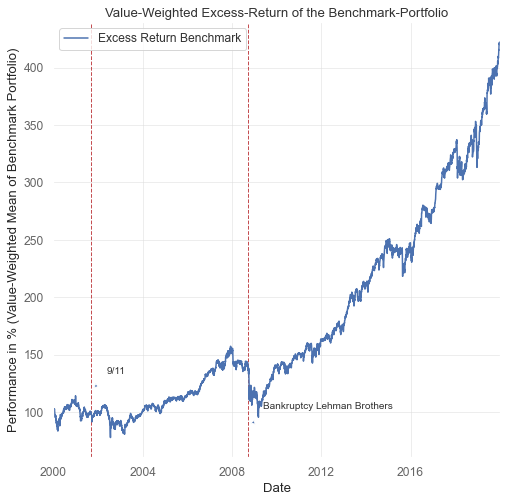

In [57]:
plot_benchmark_performance(df=df_betas, column_ret='ret', column_weight='weightage_pct')

# Option-Implied Data and Option Metrics
## GLB and MFIS

In [58]:
# merge data with glb
df_stocks_betas_options = pd.merge(df_betas, df_glb, how="left", on=['permno', 'date'])
# merge data with mfis
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_mfis, how='left', on=['permno', 'date'])

### Average Volatility [AIV] of all OTM Call and Put Options and SKEW

In [59]:
def retrieve_option_metrics(df, start_year, end_year, days, delta_otm_put, delta_atm_call, delta_otm_put2, delta_atm_call2, wrds_username):
    
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # define the parameters
    params = {}
    params['secids'] = tuple(df.secid.unique())
    params['days'] = days
    params['delta_otm_put'] = delta_otm_put
    params['delta_atm_call'] = delta_atm_call
    params['delta_otm_put2'] = delta_otm_put2
    params['delta_atm_call2'] = delta_atm_call2

    # define the sql query
    sql = '''
    select a.date, a.secid, a.iv-b.iv as skew1, c.iv, (g.iv-v.iv)/a.iv as skew2 from 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call)s) as a, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put)s) as b, 

    (select date, secid, AVG(impl_volatility) as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and abs(delta)<=%(delta_atm_call)s
    group by date, secid) as c,
    
    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put2)s) as g, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call2)s) as v

    where a.date= b.date and a.secid = b.secid 
    and a.date = c.date and a.secid = c.secid
    and a.date = g.date and a.secid = g.secid
    and a.date = v.date and a.secid = v.secid
    '''
    # retrieve data for 1999
    params['year'] = start_year
    df_optiondata = db.raw_sql(sql, params = params)

    # append data for each year from 2000 to 2020
    for y in tqdm(range(start_year+1,end_year)):
        #print('Processing year ', y)
        # set parameter for the year
        params['year'] = y
        df_optiondata = pd.concat([df_optiondata, db.raw_sql(sql, params = params)])
        
    return df_optiondata

In [60]:
df_option_metrics = retrieve_option_metrics(df=df_stocks_betas_options,
                                            start_year=1999,
                                            end_year=2020,
                                            days=30,
                                            delta_otm_put=-10,
                                            delta_atm_call=50,
                                            delta_otm_put2=-25,
                                            delta_atm_call2=25,
                                            wrds_username="strahinja23")

# change type of entries in the column data
df_option_metrics.loc[:,'date'] = pd.to_datetime(df_option_metrics.loc[:,'date'])

# merge optiondata and stockdata
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_option_metrics, how='left', on=['secid', 'date'])

Loading library list...
Done


100%|██████████| 20/20 [00:48<00:00,  2.44s/it]


## Technical Indicators

In [61]:
def technicals_rock(df_a):
    
    KAMA = KAMAIndicator(close = df_a["prc"],window = 10,pow1 = 2, pow2 = 30)
    PPO = PercentagePriceOscillator(close = df_a["prc"],window_slow = 26, window_fast = 12, window_sign = 9)
    ROCI = ROCIndicator(close=df_a["prc"],window=12)
    RSI = RSIIndicator(close=df_a["prc"],window = 14)
    EMA14 = EMAIndicator(close = df_a["prc"],window = 14)
    EMA25 = EMAIndicator(close = df_a["prc"],window = 25)
    MACD_ind = MACD(close = df_a["prc"],window_slow = 26,window_fast = 12,window_sign=9)
    Aroon = AroonIndicator(close = df_a["prc"],window = 25)
    
    df_a = df_a.assign(    
    KAMA = KAMA.kama(),
    PPO = PPO.ppo_signal(),
    ROCI = ROCI.roc(),
    RSI = RSI.rsi(),
    EMA14 = EMA14.ema_indicator(),
    EMA25 = EMA25.ema_indicator(),
    MACD = MACD_ind.macd_signal(),
    AroonInd = Aroon.aroon_indicator()
    )
    
    return df_a

In [62]:
df_stocks_betas_options = technicals_rock(df_stocks_betas_options)

## Variance Risk Premium , please rewrite !

In [63]:
db = wrds.Connection(wrds_username='strahinja23')

sql = '''
select a.date,a.secid,a.return
from optionm.secprd%(year)s as a
where secid in %(secids)s
'''
params = {}
params['secids'] = tuple(df_stocks_betas_options.secid.unique())
params['year'] = 1999
options_returns = db.raw_sql(sql,params = params)

for y in range(2000,2020):
    print('Processing year ', y)
    params['year'] = y
    options_returns = pd.concat([options_returns, db.raw_sql(sql,params = params)])
    
options_returns.loc[:,'date'] = pd.to_datetime(options_returns.loc[:,'date'])
options_returns = options_returns.rename(columns={"return": "option_returns"})
options_returns = options_returns.set_index('date')

temp1 = options_returns.groupby(by=['secid'])['option_returns'].rolling(window=21).var()*252
temp1.name = 'realized_variance'
temp1 = temp1.reset_index()

df_stocks_betas_options = df_stocks_betas_options.merge(temp1,how='left',on=['date','secid'])
df_stocks_betas_options.loc[:,'vrp'] = (df_stocks_betas_options.loc[:,'iv']**2).rolling(21).sum()/(df_stocks_betas_options.loc[:,'realized_variance']).rolling(21).sum()
df_stocks_betas_options.drop(['realized_variance'], inplace=True, axis=1)

Loading library list...
Done
Processing year  2000
Processing year  2001
Processing year  2002
Processing year  2003
Processing year  2004
Processing year  2005
Processing year  2006
Processing year  2007
Processing year  2008
Processing year  2009
Processing year  2010
Processing year  2011
Processing year  2012
Processing year  2013
Processing year  2014
Processing year  2015
Processing year  2016
Processing year  2017
Processing year  2018
Processing year  2019


KeyError: "['realized_variance_x' 'realized_variance_y'] not found in axis"

In [ ]:
#df_stocks_betas_options.to_hdf(hdf_path, key = 'factors', mode= 'a',data_columns = True, complib = 'zlib')
#df_stocks_betas_options = pd.read_hdf(hdf_path,key='factors')

# Data Cleaning

## Delete Columns with many NaNs

In [67]:
def count_nan(df):
    # Count NaN
    df_count_nan = df.isna().sum().reset_index(name="Count NaN")
    # Rename column
    df_count_nan = df_count_nan.rename(columns={"index": "Column"})
    # Plot
    df_count_nan.plot.bar(x='Column', 
                          y='Count NaN', 
                          rot=45, 
                          figsize=(16,6), 
                          title="Count NaN per Column")

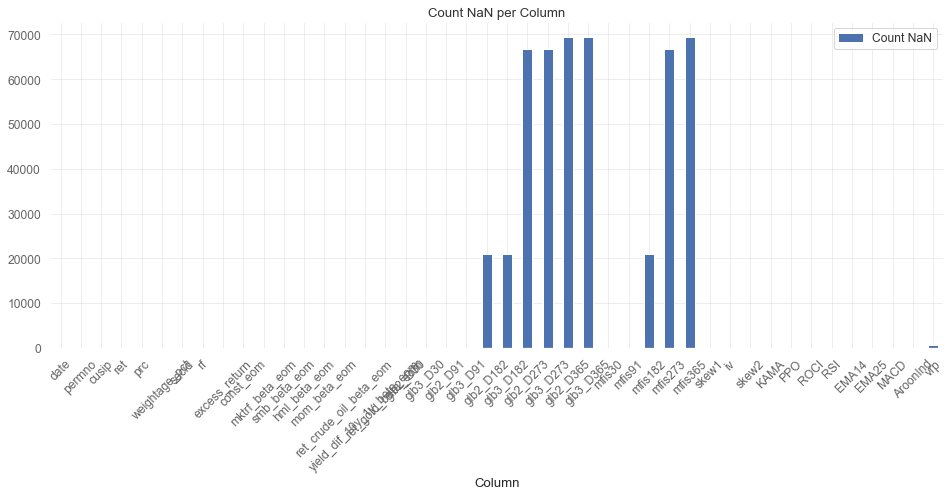

In [68]:
count_nan(df=df_stocks_betas_options)

In [69]:
# drop columns with many nas
df_stocks_betas_options.drop(['glb2_D182', 
                              'glb3_D182', 
                              'glb2_D273', 
                              'glb3_D273', 
                              'glb2_D365', 
                              'glb3_D365',
                              'mfis182',
                              'mfis273', 
                              'mfis365'], inplace=True, axis=1)

## Multicollinearity

In [70]:
def corrmatrix_heatmap(df, columns):
    
    X = df[columns]

    # Compute the correlation matrix
    corrMatrix = X.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 11))

    sns.heatmap(corrMatrix, annot=True)
    # plt.savefig('corrMatrix_heatmap.jpeg', dpi=200, format='jpeg')

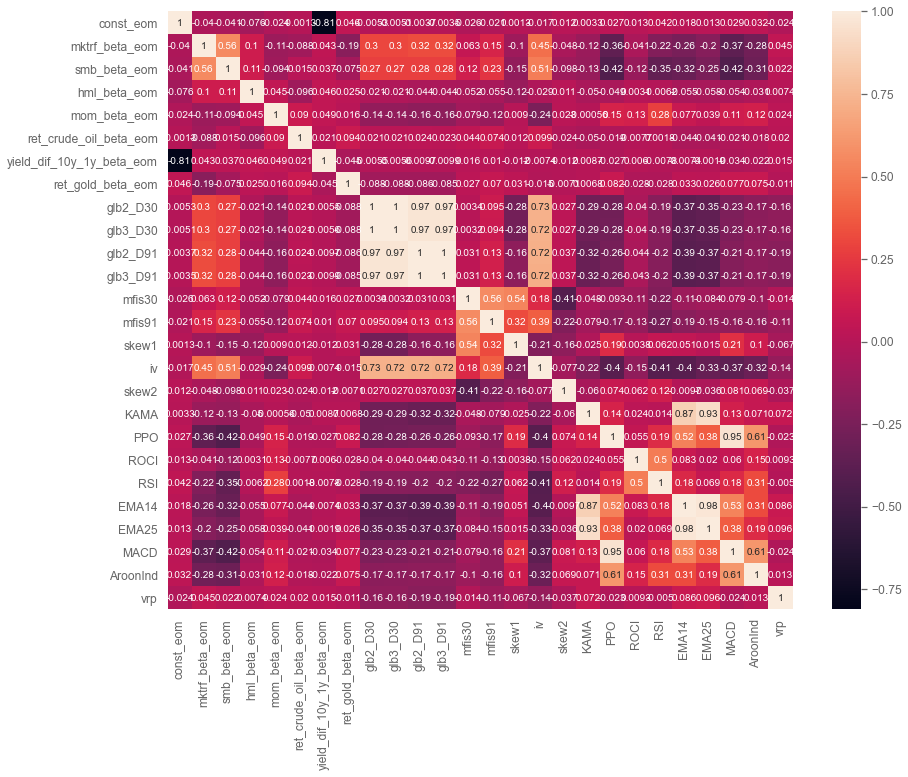

In [71]:
# define columns to calculate pearson correlation coefficient for
idx = list(df_stocks_betas_options.columns).index("excess_return")
columns = list(df_stocks_betas_options.columns)[idx+1:]

# execute function
corrmatrix_heatmap(df=df_stocks_betas_options, columns=columns)

In [72]:
def VIF_Features(df):
    
    X_ = df.copy()
    X_ = X_[X_.columns[10:]]
    X_ = X_.dropna()
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_.columns
    vif_data["VIF"] = [variance_inflation_factor(X_.values, i) for i in range(len(X_.columns))]
    
    return vif_data

In [73]:
# drop columns
df_stocks_betas_options.drop(['glb2_D30', 
                              #'glb3_D30', 
                              'glb2_D91', 
                              'glb3_D91',
                              'mfis30',
                             'EMA25',
                              'EMA14',
                              'KAMA'
                             ], inplace=True, axis=1)

In [74]:
dd = VIF_Features(df_stocks_betas_options)
dd

,feature,VIF
0,mktrf_beta_eom,9.258317
1,smb_beta_eom,1.907057
2,hml_beta_eom,1.060757
3,mom_beta_eom,1.143140
4,ret_crude_oil_beta_eom,1.077343
5,yield_dif_10y_1y_beta_eom,1.010883
6,ret_gold_beta_eom,1.079325
7,glb3_D30,4.095048
8,mfis91,5.631707
9,skew1,2.665618


## Returns, Train, Test Split and Normalization

In [75]:
def alpha_returns(df,kind):
    if kind == 'Alpha':
        benchmark_returns = df.groupby(['date'])[['weightage_pct','ret']].apply(lambda x: np.nansum(x['ret']*x['weightage_pct']))
        benchmark_returns.name = 'ret_benchmark'                     
        df = df.merge(benchmark_returns, on=['date'])
        df['ret_bm_fw'] = df.groupby(['permno'])['ret_benchmark'].shift(-1)
        df.loc[:,'fret1d'] = df.groupby(['permno'])['ret'].shift(-1)
        df['fret1d'] = df['fret1d'] - df['ret_bm_fw']
        df.drop(columns = {'ret_bm_fw', 'ret_benchmark'}, inplace = True)
    if kind == 'Regular':
        df.loc[:,'fret1d'] = df.groupby(['permno'])['ret'].shift(-1)
    
    return df

In [76]:
df_stocks_betas_options = alpha_returns(df_stocks_betas_options,kind = 'Regular')

In [77]:
def train_test_split_sorted(df,date_of_split, dates):   
    
    date_of_split = pd.to_datetime(date_of_split)
    X_train = df[(df["date"] <= date_of_split) & (df['date'] > pd.datetime(1999, 12, 31))]
    X_test = df[(df["date"] > date_of_split) & (df['date'] < pd.datetime(2020, 1, 1))]
    
    X_train = X_train.sort_values(by=['date','permno'])
    X_test = X_test.sort_values(by=['date','permno'])

    return X_train,X_test

In [78]:
df_stocks_betas_options.loc[:,'date'] = pd.to_datetime(df_stocks_betas_options.loc[:,'date'])


train,test = train_test_split_sorted(df=df_stocks_betas_options,
                                     date_of_split=pd.datetime(2012, 12, 31),
                                     dates=df_stocks_betas_options.date)

In [79]:
def process(df,columns):
    df_scaled = df.copy()

    df_scaled = df_scaled.fillna(method='ffill',limit=30,inplace=False)
    df_scaled = df_scaled.dropna()
    
    for column in columns:
       
    # df_scaled[column] = (df_scaled[column] - df_scaled[column].mean())  / df_scaled[column].std()
        df_scaled[column] = (df_scaled[column] - df_scaled[column].min())  / (df_scaled[column].max() - df_scaled[column].min())
        df_scaled[column], fitted_lambda = stats.boxcox(df_scaled[column] + 0.0001) 
        df_scaled.loc[:,column] = winsorize(df_scaled.loc[:,column], limits=0.01).data
        df_scaled[column] -= df_scaled[column].mean()
                                                                     
    
    return df_scaled

In [85]:
columns2norm = train.columns[10:-1]

# Only the train gets processed, the rest will be processed on a rolling window in the testing phase
train = process(train, columns2norm)

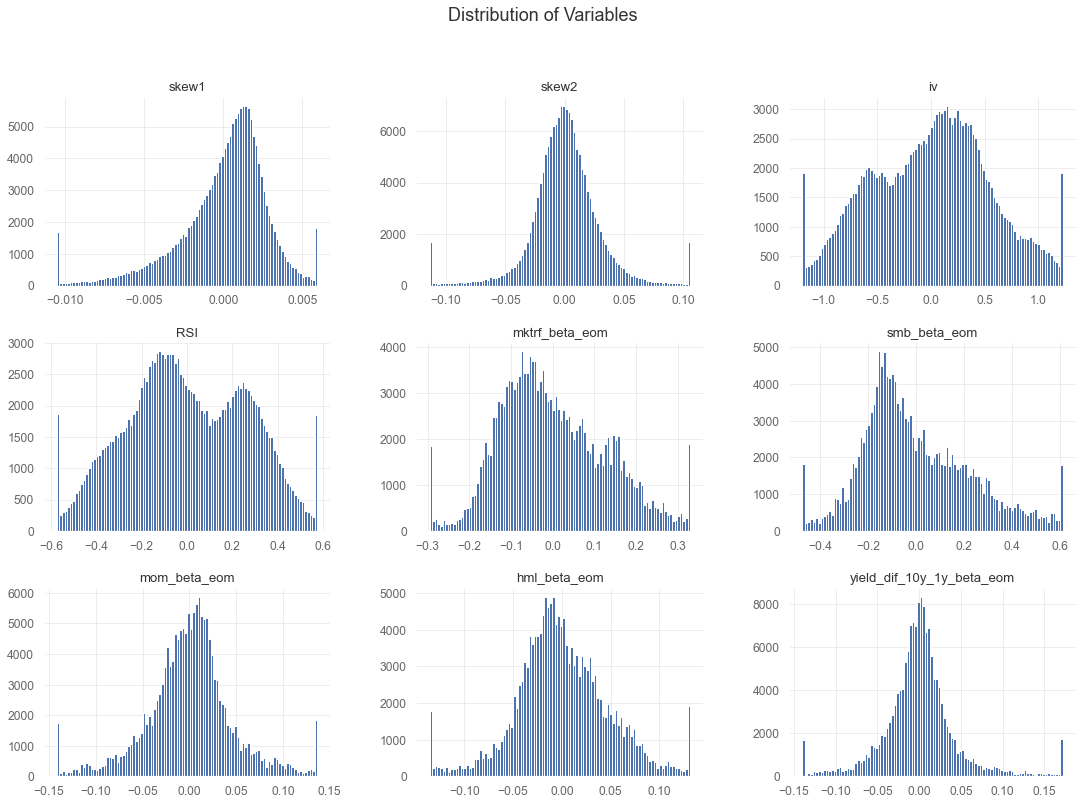

In [86]:
cols = ['skew1', 'skew2', 'iv','RSI','mktrf_beta_eom','smb_beta_eom','mom_beta_eom','hml_beta_eom','yield_dif_10y_1y_beta_eom' ]#,'vrp', 'AroonInd']
fig, axs = plt.subplots(3,3)
fig.set_size_inches(18.5, 12.5, forward=True)
fig.suptitle('Distribution of Variables', fontsize=18)

for i,el in enumerate(cols):
    a = train.hist(el, ax=axs.flatten()[i],bins=100)


## Modelling the Prediction of Returns

In [120]:
def Rolling_Forest(data,predictors,target,window,params):

# First we form the window 
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

#Auxiliary placeholders and reg. constant
    data = data.sort_values(by=['date','permno'])
    predictions_df = pd.DataFrame(index=[pred_date], columns=np.sort(data.permno.unique()))
    scores = []
    missing_dates = []

# The train / predict loop
    while pred_date <= data.date.max():
# The loop will go through business days, not necessarily trading days (hence the try clause).        
        try:
        # Picking the window of data to train and instantiating the predictor model
            mask = ((data['date'] >= start_window) & (data['date'] <= end_window))
            train_window = data[mask].set_index('permno')
            linreg = RandomForestRegressor(**params)
        # Fitting the model on the training window     
            fit_ = linreg.fit(train_window[list(predictors)],train_window[target])
        # Predicting for each permno on the next day after fit    
            predi_df = data[data['date']== pred_date].loc[:,list(predictors)+['permno']].set_index('permno')
            predi = fit_.predict(predi_df)
        # Storing in a useful format for backtest
            one_predi = (pd.DataFrame(data = predi, index=predi_df.index,columns=[pred_date])).T
            predictions_df = pd.concat([predictions_df,one_predi], axis=0, ignore_index=False)
       # R^2 to help visualize training performance     
            score_r2 = linreg.score(predi_df[list(predictors)], data[data['date']== pred_date][target])
            scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
# Update window position        
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
# Real returns we will need

    # real_returns = data.pivot_table(index='date', columns='permno', values='fret1d')
    real_returns = data.pivot(index='date', columns='permno', values='fret1d')
   # r2_average = np.mean(scores)
    
    return real_returns, predictions_df[1:], missing_dates,scores #, r2_average
    # return data

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
params = {
        'n_estimators': [10, 20, 30],
        'max_features': ['sqrt','auto','log2'],
        'max_depth': [3, 4, 5],
        'min_samples_leaf':[1,2,3,4],
        'min_samples_split':[2,3,4,5]
        }

train.insert(10, 'constant', 1.0)
regressors = train.columns[10:-1]
target = ['fret1d']


forest = RandomForestRegressor()

folds = 3
param_comb = 5

random_search = RandomizedSearchCV(forest, param_distributions=params, n_iter=param_comb, scoring='r2', 
                                   n_jobs=4, cv=KFold(5), verbose=3, random_state=1001 )
                                                #KFold is not shuffled !

# Here we go 
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(train[regressors], train[target])
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

In [ ]:
params_forest = {
    "n_estimators": 30,
    'max_features':'sqrt', 
    'max_depth':5,
    'min_samples_leaf':3,
    'min_samples_split':4,
    'random_state':1001,
    }

#train.insert(10, 'constant', 1.0) MAKE SURE TO RUN IF NOT ALREADY INSERTED IN GRIDSEARCH !
regressors = train.columns[10:-1]
target = ['fret1d']

real_returns_forest, expected_returns_forest, missing_dates_forest, scores_forest = Rolling_Forest(data=train, 
                                                              predictors=regressors,
                                                              target=target, 
                                                              window=126,
                                                              params=params_forest)

In [ ]:
np.min(scores_forest)

## Lasso

We will tune the alpha on the whole train set and then again apply a rolling approach to predict

In [ ]:
def lasso_regression(data, predictors, target, alpha):
    
    lasso = Lasso(alpha=alpha,normalize=True, max_iter=1e5).fit(data[predictors],data[target])
    predi = lasso.predict(data[predictors]) 
    score=lasso.score(data[predictors],data[target])
    n = np.sum(lasso.coef_!=0)
    mse=metrics.mean_squared_error(data[target].to_numpy(), predi)
    
    return mse, score,n


In [ ]:
regressors

In [ ]:
alpha_lasso = [1e-16,1e-8, 1e-4, 1e-2, 1, 10]
res = pd.DataFrame(index =alpha_lasso, columns=['MSE'])
for i in range(len(alpha_lasso)):
    res.loc[alpha_lasso[i],'MSE'],  res.loc[alpha_lasso[i],'Score'],\
    res.loc[alpha_lasso[i],'No.'] = lasso_regression(train,regressors,target, alpha_lasso[i])

In [ ]:
def Rolling_Lasso(data,predictors,target,window,alpha):

# First we form the window 
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

#Auxiliary placeholders and reg. constant
    data = data.sort_values(by=['date','permno'])
    predictions_df = pd.DataFrame(index=[pred_date], columns=np.sort(data.permno.unique()))
    scores = []
    missing_dates = []

# The train / predict loop
    while pred_date <= data.date.max():
# The loop will go through business days, not necessarily trading days (hence the try clause).        
        try:
        # Picking the window of data to train and instantiating the predictor model
            mask = ((data['date'] >= start_window) & (data['date'] <= end_window))
            train_window = data[mask].set_index('permno')
            linreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
        # Fitting the model on the training window     
            fit_ = linreg.fit(train_window[list(predictors)],train_window[target])
        # Predicting for each permno on the next day after fit    
            predi_df = data[data['date']== pred_date].loc[:,list(predictors)+['permno']].set_index('permno')
            predi = fit_.predict(predi_df)
        # Storing in a useful format for backtest
            one_predi = (pd.DataFrame(data = predi, index=predi_df.index,columns=[pred_date])).T
            predictions_df = pd.concat([predictions_df,one_predi], axis=0, ignore_index=False)
       # R^2 to help visualize training performance     
            score_r2 = linreg.score(predi_df[list(predictors)], data[data['date']== pred_date][target])
            scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
# Update window position        
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
# Real returns we will need

    # real_returns = data.pivot_table(index='date', columns='permno', values='fret1d')
    real_returns = data.pivot(index='date', columns='permno', values='fret1d')
   # r2_average = np.mean(scores)
    
    return real_returns, predictions_df[1:], missing_dates,scores #, r2_average
    # return data

In [ ]:
real_returns_lasso, expected_returns_lasso, missing_dates_lasso, scores_lasso = Rolling_Lasso(data=train, 
                                                              predictors=regressors,
                                                              target=target, 
                                                              window=126,
                                                              alpha=1e-8)

In [ ]:
np.mean(scores_lasso)

In [ ]:
# expected_returns_forest.to_hdf(hdf_path, key = 'Predictions', mode= 'a',data_columns = True, complib = 'zlib')
# real_returns_forest.to_hdf(hdf_path, key = 'Real', mode= 'a',data_columns = True, complib = 'zlib')

In [ ]:
real_returns = pd.read_hdf(hdf_path,key='Real')
expected_returns = pd.read_hdf(hdf_path,key='Predictions')

## Backtest

In [88]:
def prepare_returns(real, expected, days_to_test,years_lookback):


    real = real.loc[np.logical_and(real.index >= days_to_test - pd.Timedelta(days=252*years_lookback + 1), real.index < days_to_test), :]
    expected = expected.loc[np.logical_and(expected.index >= days_to_test - pd.Timedelta(days=252*years_lookback + 1), expected.index < days_to_test), :]   
    
    real = real.fillna(0.0)
    expected = expected.fillna(0.0)
    
    return real, expected

In [ ]:
real,ret = prepare_returns(real_returns,expected_returns,pd.datetime(2012, 12, 28),5)

In [89]:
def MSR(wvec,*args):
     cov = args[0]
     mu  = args[1]  # Max Sharp Ratio
     sr = mu@wvec/(wvec@cov@wvec)
     return -sr * 1e9

def MVP(wvec,*args):
     cov = args[0]
     var = wvec@cov@wvec
     return var

In [332]:
def Benchmark_Drawdown_Rolling(df,ret,d,lookback):
    
    d = pd.Timestamp(d)
    start = d - BDay(lookback)
    
    means = ret.loc[start:(d-BDay(1)),:].values
    means_df = ret.loc[start:(d-BDay(1)),:]

    weights_bench = df[(df['date']>= start) & (df['date'] < d)]
    weights_bench = weights_bench[['date','permno','weightage_pct']]
    weights_bench = weights_bench.pivot(index = 'date',columns = 'permno',values='weightage_pct')
    weights_bench = weights_bench.loc[weights_bench.index.isin(means_df.index)]
    
    monthly_benchmark_returns = (means*weights_bench).sum(axis=1)
    monthly_benchmark_returns = pd.DataFrame(monthly_benchmark_returns,columns=["Benchmark_Return"])
    # cumulative return
    monthly_benchmark_returns['Cum_ret'] = (1+ monthly_benchmark_returns['Benchmark_Return']).cumprod()
    # cumulative peaks
    monthly_benchmark_returns['Peaks'] = monthly_benchmark_returns['Cum_ret'].cummax()
    # drawdown from trailing peak
    monthly_benchmark_returns['Drawdown'] = (monthly_benchmark_returns['Cum_ret'] - monthly_benchmark_returns['Peaks']) / monthly_benchmark_returns['Peaks']
    
    return monthly_benchmark_returns, monthly_benchmark_returns['Drawdown'].min()

In [333]:
def configure_inputs_for_optimisation(df, ret, expret, d, limit,lookback):

    cov = ret.cov().values
    mu  = expret.iloc[-1].values
    mu = mu - np.mean(mu)
    mu = winsorize(mu, limits=0.1).data
 
    if np.sum(mu > 0) == 0:
        mu -= mu.mean()
    
 # ----- Bounds on Weights Based on Benchmark on day d  ---- #
    bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
    for en,i in enumerate(ret.columns, start=0): # 
        try:
            lower_bound = 0.9*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
            higher_bound = 1.1*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
            bounds[en].extend((lower_bound,higher_bound))
        except:
            lower_bound = 0.0
            higher_bound = 0.0
            bounds[en].extend((lower_bound,higher_bound))
              
 # ----- Constraints on Factor Exposure: ---- #
    cons = []
    fact = pd.DataFrame(columns=list(regressors)+['permno'] )
    fact.permno = ret.columns.tolist()
    fact.set_index('permno', inplace=True)
    fact = fact.fillna(0.0)

    #Exposure of strategy

    for stock in fact.index:
        for fct in fact.columns:
            flt = np.logical_and(df['date'] == d, df['permno'] == stock)
            if flt.any():
                fact.loc[stock, fct] = df.loc[flt, fct].values[0]
    
    
    B = fact.T[1:]
    
    # Benchmark Weights
    weights_Benchmark = df.loc[df['date']==d][['permno','weightage_pct']]
    weights_Benchmark = weights_Benchmark.sort_values('permno')
    weights_Benchmark = weights_Benchmark.set_index(['permno']).squeeze()
    for i in df.permno.unique():
        if i not in weights_Benchmark.index:
            weights_Benchmark[i] = 0.0
    weights_Benchmark = weights_Benchmark.sort_index()
    
    
    cons.append({'type': 'ineq', 'fun' : lambda wvec: B@weights_Benchmark- B@wvec + limit})
    cons.append({'type': 'ineq', 'fun' : lambda wvec: B@wvec -B@weights_Benchmark + limit}) 
 
 # ----- Constraints on Weight Sum (long portfolio): ---- #

    cons.append({'type': 'eq', 'fun' : lambda wvec: wvec.sum()-1})
    
#  # ----- Constraints on Drawdown: ---- #
    if (pd.Timestamp(d)- BDay(lookback)) in ret.index:
        _,benchmark_dd = Benchmark_Drawdown_Rolling(df,ret,d,21)
        cons.append({'type': 'ineq', 'fun' : lambda wvec: mu.T@wvec-(benchmark_dd-0.01)})        
    
    return cov, mu, cons, bounds

## Sanity Check on Weight Bounds

In [ ]:
dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='B')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values                   # But less realistic (daily trading)

In [ ]:
bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
d = dates_rebal[0]
for en,i in enumerate(ret.columns, start=0): # 

    lower_bound = 0.9*float(train.loc[train['date']==d][train['permno']== i].weightage_pct.values)
    higher_bound = 1.1*float(train.loc[train['date']==d][train['permno']== i].weightage_pct.values)
    bounds[en].extend((lower_bound,higher_bound))

In [ ]:
bounds[11] # Alles gut ! 

In [ ]:
train.loc[train['date']==dates_rebal[0]][train['permno']== ret.columns[11]].weightage_pct.values

## Sanity Check on Factor Exposure

In [ ]:
fact = pd.DataFrame(columns=list(regressors)+['permno'] )
fact.permno = ret.columns.tolist()
fact.set_index('permno', inplace=True)
fact = fact.fillna(0.0)

In [ ]:
for stock in fact.index:
    for fct in fact.columns:
        flt = np.logical_and(train['date'] == dates_rebal[0], train['permno'] == stock)
        if flt.any():
            fact.loc[stock, fct] = train.loc[flt, fct].values[0]

In [ ]:
#fact

## Run the whole loop on Weekly rebalance

In [ ]:
dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='B')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values # But less realistic (daily trading)

 # We need to also exclude from rebalance dates the business days that were actually not trading days
# #missing_dates = [i.to_datetime64() for i in missing_dates] # Uncomment if needed a convert!
dates_rebal = [x for x in dates_rebal if x not in missing_dates_forest]

In [ ]:
len(dates_rebal)

In [ ]:
names = ret.columns
ptf = {} 

# Initiate a dictionary of placeholders for the 3 strategies
ptf['msr_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = names)
ptf['minvar_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = names)

In [ ]:
# Optimization rutine for the 2 minimization problems and for the closed form solution
st_point_msr = None
st_point_mvp = None

for d in dates_rebal: 
    print(d)    
    start_time = time.time()

    ret, expret = prepare_returns(real_returns,expected_returns,d)

    # we prepare inputs:
    cov,mu,cons,bounds = configure_inputs_for_optimisation(train, ret, expret, d, 0.05,21)

    # define starting point
    if st_point_msr is None:
        st_point_msr = np.ones(ret.columns.size)/ret.columns.size
    if st_point_mvp is None:
        st_point_mvp = np.ones(ret.columns.size)/ret.columns.size

    # run optimisation, MSR
    res = minimize(MSR,
                st_point_msr,
                args = (cov, mu), 
                constraints = cons, 
                bounds = bounds, 
                method = 'SLSQP',
                options={'ftol': 1e-16, 'disp': False})
    print("MSR: " + res.message)
    
    st_point_msr = res.x

    # store results
#     i = 0
#     for col in ret.columns:
#         ptf['msr_w_cons'].loc[d, col] = res.x[i]
#         i += 1
    ptf['msr_w_cons'].loc[d] = res.x
    
    res = minimize(MVP,
                st_point_mvp,
                args = (cov, mu), 
                constraints = cons, 
                bounds = bounds, 
                method = 'SLSQP',
                options={'ftol': 1e-16, 'disp': False})
    
    print("MVP: " + res.message)
    ptf['minvar_w_cons'].loc[d] = res.x

    # Set next starting point
    st_point_mvp = res.x

    
    print("--- %s seconds ---" % (time.time() - start_time))

In [340]:
def clc_str_return(w, ret, str_name):
    w_i = np.zeros(len(ret.columns.tolist()))
    ret_str = pd.DataFrame(index = ret.index, columns=[str_name])
    for i in ret.index:
        ret_str.loc[i, str_name] = w_i@ret.loc[i,:]
        #ret_str.loc[i, str_name] = np.sum(w_i)
        if i in w.index:
            w_i = w.loc[i,:]
#             scalor = max(sum(w_i[w_i>0]), sum(-1 * w_i[w_i<0]))
#             w_i[w_i>0] = w_i[w_i>0]/scalor
#             w_i[w_i<0] = w_i[w_i<0]/scalor
#             w_i[w_i>0] = w_i[w_i>0]/sum(w_i[w_i>0])
#             w_i[w_i<0] = w_i[w_i<0]/sum(-1 * w_i[w_i<0])
     
    return ret_str

In [ ]:
ret_str = clc_str_return(ptf['msr_w_cons'], ret, 'msr_w_cons')
ret_str = ret_str.join(clc_str_return(ptf['minvar_w_cons'], ret, 'minvar_w_cons'))

## Compare with Benchmark

In [ ]:
#ret_str.to_hdf(hdf_path, key = 'Portfolio_Plot', mode= 'a',data_columns = True, complib = 'zlib')
#ret_str = pd.read_hdf(hdf_path,key='Portfolio_Plot')

In [ ]:
bnch_ret = (df_betas.groupby(['date']).apply(weighted_avg, 'ret', 'weightage_pct')+1).cumprod()
bnch_ret = bnch_ret.loc[(bnch_ret.index >= ret_str.index.min()) & (bnch_ret.index <= ret_str.index.max())]

In [ ]:
rep_ = qs.reports.html(ret_str['msr_w_cons'],bnch_ret)

In [ ]:
dd_ = qs.reports.html(ret_str['minvar_w_cons'],bnch_ret)

## Test Set Predictions

The function is only different so that it also normalizes the rolling window we are fitting/testing on .This is important so we avoid lookahead bias in our test set.

In [334]:
def Rolling_Forest_Test(data,predictors,target,window,params):

# First we form the window 
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

#Auxiliary placeholders and reg. constant
    data = data.sort_values(by=['date','permno'])
    predictions_df = pd.DataFrame(index=[pred_date], columns=np.sort(data.permno.unique()))
    scores = []
    missing_dates = []

# The train / predict loop
    while pred_date <= data.date.max():
# The loop will go through business days, not necessarily trading days (hence the try clause).        
        try:
        # Picking the window of data to train and instantiating the predictor model
            mask = ((data['date'] >= start_window) & (data['date'] <= end_window))
            train_window = data[mask].set_index('permno')
            train_window = process(train_window,list(predictors)[1:])
            linreg = RandomForestRegressor(**params)
        # Fitting the model on the training window     
            fit_ = linreg.fit(train_window[list(predictors)],train_window[target])
        # Predicting for each permno on the next day after fit    
            predi_df = data[data['date']== pred_date].loc[:,list(predictors)+['permno']].set_index('permno')
            predi = fit_.predict(predi_df)
        # Storing in a useful format for backtest
            one_predi = (pd.DataFrame(data = predi, index=predi_df.index,columns=[pred_date])).T
            predictions_df = pd.concat([predictions_df,one_predi], axis=0, ignore_index=False)
       # R^2 to help visualize training performance     
            score_r2 = linreg.score(predi_df[list(predictors)], data[data['date']== pred_date][target])
            scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
# Update window position        
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
# Real returns we will need

    # real_returns = data.pivot_table(index='date', columns='permno', values='fret1d')
    real_returns = data.pivot(index='date', columns='permno', values='fret1d')
   # r2_average = np.mean(scores)
    
    return real_returns, predictions_df[1:], missing_dates,scores #, r2_average
    # return data

In [187]:
params_forest = {
    "n_estimators": 30,
    'max_features':'sqrt', 
    'max_depth':5,
    'min_samples_leaf':3,
    'min_samples_split':4,
    'random_state':1001,
    }

#test.insert(10, 'constant', 1.0)# MAKE SURE TO RUN IF NOT ALREADY INSERTED IN GRIDSEARCH !
regressors = test.columns[10:-1]
target = ['fret1d']

real_returns_forest_test, expected_returns_forest_test, missing_dates_forest_test, scores_forest_test = Rolling_Forest_Test(data=test, 
                                                              predictors=regressors,
                                                              target=target, 
                                                              window=21,
                                                              params=params_forest)
real_returns_forest_test = real_returns_forest_test[real_returns_forest_test.index >= expected_returns_forest_test.index.min()]

In [335]:
ret, expret = prepare_returns(real_returns_forest_test,expected_returns_forest_test,pd.datetime(2019, 12, 31),9)

In [336]:
dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='B')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values # But less realistic (daily trading)

 # We need to also exclude from rebalance dates the business days that were actually not trading days
# #missing_dates = [i.to_datetime64() for i in missing_dates] # Uncomment if needed a convert!
dates_rebal = [x for x in dates_rebal if x not in missing_dates_forest_test]

#dates_ = [i.date() for i in dates_rebal]
real_returns_forest_test = real_returns_forest_test.loc[~real_returns_forest_test.index.isin(missing_dates_forest_test)]
expected_returns_forest_test = expected_returns_forest_test.loc[~expected_returns_forest_test.index.isin(missing_dates_forest_test)]

In [337]:
names = ret.columns
ptf = {} 

# Initiate a dictionary of placeholders for the 3 strategies
ptf['msr_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = names)
ptf['minvar_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = names)

In [338]:
# Optimization rutine for the 2 minimization problems and for the closed form solution
st_point_msr = None
st_point_mvp = None

for d in dates_rebal: 
    print(d)    
    start_time = time.time()

    ret, expret = prepare_returns(real_returns_forest_test,expected_returns_forest_test,d,3)

    # we prepare inputs:
    cov,mu,cons,bounds = configure_inputs_for_optimisation(test, ret, expret, d, 0.05,21)

    # define starting point
    if st_point_msr is None:
        st_point_msr = np.ones(ret.columns.size)/ret.columns.size
    if st_point_mvp is None:
        st_point_mvp = np.ones(ret.columns.size)/ret.columns.size

    # run optimisation, MSR
    res = minimize(MSR,
                st_point_msr,
                args = (cov, mu), 
                constraints = cons, 
                bounds = bounds, 
                method = 'SLSQP',
                options={'ftol': 1e-16, 'disp': False})
    print("MSR: " + res.message)
    
    st_point_msr = res.x

    # store results
#     i = 0
#     for col in ret.columns:
#         ptf['msr_w_cons'].loc[d, col] = res.x[i]
#         i += 1
    ptf['msr_w_cons'].loc[d] = res.x
    
    res = minimize(MVP,
                st_point_mvp,
                args = (cov, mu), 
                constraints = cons, 
                bounds = bounds, 
                method = 'SLSQP',
                options={'ftol': 1e-16, 'disp': False})
    
    print("MVP: " + res.message)
    ptf['minvar_w_cons'].loc[d] = res.x

    # Set next starting point
    st_point_mvp = res.x

    
    print("--- %s seconds ---" % (time.time() - start_time))

2013-10-14T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.735893726348877 seconds ---
2013-10-15T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.556530714035034 seconds ---
2013-10-16T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 7.734820127487183 seconds ---
2013-10-17T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 6.298471927642822 seconds ---
2013-10-18T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 5.2929229736328125 seconds ---
2013-10-21T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 5.311084747314453 seconds ---
2013-10-22T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Posi

MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.625630617141724 seconds ---
2014-01-03T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Positive directional derivative for linesearch
--- 5.4826741218566895 seconds ---
2014-01-06T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.034699440002441 seconds ---
2014-01-07T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.697700262069702 seconds ---
2014-01-08T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.595444917678833 seconds ---
2014-01-09T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.191002607345581 seconds ---
2014-01-10T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.009207010269165 seconds --

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.0243353843688965 seconds ---
2014-03-26T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 5.641721725463867 seconds ---
2014-03-27T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 4.956205129623413 seconds ---
2014-03-28T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 5.693570613861084 seconds ---
2014-03-31T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.50569486618042 seconds ---
2014-04-01T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.2467732429504395 seconds ---
2014-04-02T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration li

MSR: Singular matrix E in LSQ subproblem
MVP: Singular matrix E in LSQ subproblem
--- 1.255277395248413 seconds ---
2014-06-13T00:00:00.000000000
MSR: Singular matrix E in LSQ subproblem
MVP: Singular matrix E in LSQ subproblem
--- 1.2978086471557617 seconds ---
2014-06-16T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 5.571980953216553 seconds ---
2014-06-17T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 3.7467448711395264 seconds ---
2014-06-18T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 7.312807321548462 seconds ---
2014-06-19T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 7.136774063110352 seconds ---
2014-06-20T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 8.30855393409729

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.916579484939575 seconds ---
2014-09-02T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.694625377655029 seconds ---
2014-09-03T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.62947940826416 seconds ---
2014-09-04T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.9670166969299316 seconds ---
2014-09-05T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 3.2729365825653076 seconds ---
2014-09-08T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.9628734588623047 seconds ---
2014-09-09T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.299578905105591 second

MVP: Iteration limit reached
--- 6.217983961105347 seconds ---
2014-11-20T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 5.301907062530518 seconds ---
2014-11-21T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.4489569664001465 seconds ---
2014-11-24T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 7.097109794616699 seconds ---
2014-11-25T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.4074790477752686 seconds ---
2014-11-26T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.795238494873047 seconds ---
2014-11-28T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.164188861846924 seconds ---
2014-12-01T00:00:00.000000000
MSR: Ine

MVP: Iteration limit reached
--- 5.549473524093628 seconds ---
2015-02-11T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 3.9168636798858643 seconds ---
2015-02-12T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 3.5810744762420654 seconds ---
2015-02-13T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.785658359527588 seconds ---
2015-02-17T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.683633327484131 seconds ---
2015-02-18T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.8383119106292725 seconds ---
2015-02-19T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.028473138809204 seconds ---
2015-02-20T00:00:00.000000000
MSR: Positive directional deri

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.789285182952881 seconds ---
2015-05-05T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.7849202156066895 seconds ---
2015-05-06T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.703207492828369 seconds ---
2015-05-07T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.7564806938171387 seconds ---
2015-05-08T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.619145631790161 seconds ---
2015-05-11T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.877883672714233 seconds ---
2015-05-12T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesea

MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.7119975090026855 seconds ---
2015-07-27T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.896257638931274 seconds ---
2015-07-28T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.974834203720093 seconds ---
2015-07-29T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.65309476852417 seconds ---
2015-07-30T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.812379837036133 seconds ---
2015-07-31T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 5.012511491775513 seconds ---
2015-08-03T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 7.452246427536011 seconds ---
2015-08-04T00:00:00.000000000
MSR: Positive di

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.681030511856079 seconds ---
2015-10-14T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.5141589641571045 seconds ---
2015-10-15T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.3280365467071533 seconds ---
2015-10-16T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 3.9365477561950684 seconds ---
2015-10-19T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Positive directional derivative for linesearch
--- 4.878767490386963 seconds ---
2015-10-20T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 5.421168088912964 seconds ---
2015-10-21T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization term

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.829927206039429 seconds ---
2016-01-05T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.895081996917725 seconds ---
2016-01-06T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 5.843979120254517 seconds ---
2016-01-07T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.095041751861572 seconds ---
2016-01-08T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.875782489776611 seconds ---
2016-01-11T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.0899107456207275 seconds ---
2016-01-12T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.9399497509002686 seconds ---
2016-01-13T00:00:00.000

MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.9580488204956055 seconds ---
2016-03-24T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.959402322769165 seconds ---
2016-03-28T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.967625856399536 seconds ---
2016-03-29T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.351717710494995 seconds ---
2016-03-30T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.7834835052490234 seconds ---
2016-03-31T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.542065620422363 seconds ---
2016-04-01T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.597571849822998 seconds ---
2016-06-13T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.473355054855347 seconds ---
2016-06-14T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.926092624664307 seconds ---
2016-06-15T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.950949668884277 seconds ---
2016-06-16T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.880948305130005 seconds ---
2016-06-17T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.862797260284424 seconds ---
2016-06-20T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.930067300796509 seconds ---
2016-06-21T00:00:00.000000000
MSR

MVP: Iteration limit reached
--- 5.975006103515625 seconds ---
2016-08-30T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.71716570854187 seconds ---
2016-08-31T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 3.908702850341797 seconds ---
2016-09-01T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 5.057676315307617 seconds ---
2016-09-02T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Positive directional derivative for linesearch
--- 4.831503391265869 seconds ---
2016-09-06T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.037473917007446 seconds ---
2016-09-07T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Positive directional derivative for linesearch
--- 5.939627647399902 seconds ---
2016-09-08T00:00:00.000000000
MSR: Ine

MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.891001224517822 seconds ---
2016-11-18T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.891683578491211 seconds ---
2016-11-22T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.166136026382446 seconds ---
2016-11-23T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Positive directional derivative for linesearch
--- 4.809639930725098 seconds ---
2016-11-25T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.651769638061523 seconds ---
2016-11-28T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.034617900848389 seconds ---
2016-11-29T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.027930736541748 seconds ---
2016-11-30T0

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.768058776855469 seconds ---
2017-02-14T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.704659938812256 seconds ---
2017-02-15T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.614314317703247 seconds ---
2017-02-16T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.8767783641815186 seconds ---
2017-02-17T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.527361154556274 seconds ---
2017-02-21T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.534689426422119 seconds ---
2017-02-22T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 5.179757595062256 seconds -

MVP: Iteration limit reached
--- 5.67186164855957 seconds ---
2017-05-05T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.89635968208313 seconds ---
2017-05-08T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 6.630459547042847 seconds ---
2017-05-09T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 5.825653076171875 seconds ---
2017-05-10T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.821199417114258 seconds ---
2017-05-11T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.833332300186157 seconds ---
2017-05-12T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 5.32802152633667 seconds ---
2017-05-15T00:00:00.000000000
MSR: Positive directional derivati

MSR: Inequality constraints incompatible
MVP: Positive directional derivative for linesearch
--- 5.241732835769653 seconds ---
2017-07-26T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 3.8586573600769043 seconds ---
2017-07-27T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.826113939285278 seconds ---
2017-07-28T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.584081411361694 seconds ---
2017-07-31T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.726321220397949 seconds ---
2017-08-01T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.788314342498779 seconds ---
2017-08-02T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.8697237968444824 seconds

MVP: Iteration limit reached
--- 6.093346834182739 seconds ---
2017-10-13T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 6.647800445556641 seconds ---
2017-10-16T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.019354581832886 seconds ---
2017-10-17T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.991992473602295 seconds ---
2017-10-18T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.045949220657349 seconds ---
2017-10-19T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.179022550582886 seconds ---
2017-10-20T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.855012655258179 seconds ---
2017-10-23T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: 

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.997303009033203 seconds ---
2018-01-08T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.766786098480225 seconds ---
2018-01-09T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.8274967670440674 seconds ---
2018-01-10T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.226404905319214 seconds ---
2018-01-11T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.506573677062988 seconds ---
2018-01-12T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 6.195721864700317 seconds ---
2018-01-16T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.053581476211548 seconds ---
2018-01-17

MVP: Iteration limit reached
--- 6.07003378868103 seconds ---
2018-03-29T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.078293323516846 seconds ---
2018-04-02T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.529972791671753 seconds ---
2018-04-03T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.714770078659058 seconds ---
2018-04-04T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.714280366897583 seconds ---
2018-04-05T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.570970058441162 seconds ---
2018-04-06T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.067882537841797 seconds ---
2018-04-09T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP:

MVP: Optimization terminated successfully
--- 5.180044412612915 seconds ---
2018-06-20T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 6.54482102394104 seconds ---
2018-06-21T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.520053148269653 seconds ---
2018-06-22T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.600130319595337 seconds ---
2018-06-25T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.933542013168335 seconds ---
2018-06-26T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.987314939498901 seconds ---
2018-06-27T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.4162657260894775 seconds ---
2018-06-28T00:00:00.00000

MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 5.481604337692261 seconds ---
2018-09-10T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.111730098724365 seconds ---
2018-09-11T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.109603643417358 seconds ---
2018-09-12T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 3.161255121231079 seconds ---
2018-09-13T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.927528142929077 seconds ---
2018-09-14T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.250423908233643 seconds ---
2018-09-17T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 6.013318300247192 seconds ---
2018-09-18T00:00:00.000000000
M

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.7930145263671875 seconds ---
2018-11-28T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 5.1933348178863525 seconds ---
2018-11-29T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.091116666793823 seconds ---
2018-11-30T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.679898500442505 seconds ---
2018-12-03T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.840454816818237 seconds ---
2018-12-04T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.26202130317688 seconds ---
2018-12-06T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 5.355613708496094 seconds ---
2018-12-

MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.7261457443237305 seconds ---
2019-02-21T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 3.6683104038238525 seconds ---
2019-02-22T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.98722243309021 seconds ---
2019-02-25T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 2.4637601375579834 seconds ---
2019-02-26T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.452769994735718 seconds ---
2019-02-27T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.063329696655273 seconds ---
2019-02-28T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 5.445146083831787 seco

MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 4.2169482707977295 seconds ---
2019-05-13T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 8.317524433135986 seconds ---
2019-05-14T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 6.064432144165039 seconds ---
2019-05-15T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 8.324624061584473 seconds ---
2019-05-16T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.6713526248931885 seconds ---
2019-05-17T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 7.0667643547058105 seconds ---
2019-05-20T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative 

MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.232199668884277 seconds ---
2019-07-31T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.288073778152466 seconds ---
2019-08-01T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 6.00884485244751 seconds ---
2019-08-02T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.717623949050903 seconds ---
2019-08-05T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 5.793451309204102 seconds ---
2019-08-06T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Optimization terminated successfully
--- 4.252608299255371 seconds ---
2019-08-07T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Iteration limit reached
--- 5.679512023925781 seconds ---
2019-08-08T00:00:00

MVP: Optimization terminated successfully
--- 4.328611373901367 seconds ---
2019-10-17T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Positive directional derivative for linesearch
--- 5.798324108123779 seconds ---
2019-10-18T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.824971675872803 seconds ---
2019-10-21T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.909377336502075 seconds ---
2019-10-22T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Iteration limit reached
--- 5.972836256027222 seconds ---
2019-10-23T00:00:00.000000000
MSR: Inequality constraints incompatible
MVP: Positive directional derivative for linesearch
--- 5.529117584228516 seconds ---
2019-10-24T00:00:00.000000000
MSR: Positive directional derivative for linesearch
MVP: Optimization terminated successfully
--- 4.701667070388794 seconds ---
2019-1

In [346]:
ptf['msr_w_cons']

permno,10874.0,11308.0,11404.0,11786.0,13856.0,16432.0,16600.0,17144.0,17750.0,18163.0,...,75341.0,76644.0,77649.0,80539.0,82598.0,83601.0,84519.0,85663.0,86102.0,88664.0
2013-10-14,0.002014,0.106302,0.008789,0.002780,0.078698,0.003644,0.008147,0.016358,0.023576,0.136436,...,0.003344,0.002072,0.001731,0.000719,0.009217,0.001710,0.001770,0.003511,0.001884,0.002427
2013-10-15,0.002516,0.089564,0.010675,0.002295,0.066275,0.003638,0.008102,0.016340,0.019793,0.140444,...,0.003402,0.002105,0.001747,0.000611,0.009244,0.001760,0.001799,0.002877,0.001538,0.002988
2013-10-16,0.002046,0.089579,0.008692,0.002291,0.066322,0.003617,0.008132,0.016304,0.019843,0.114015,...,0.003398,0.002231,0.001748,0.000596,0.009077,0.001765,0.001453,0.002872,0.001529,0.002964
2013-10-17,0.002048,0.091512,0.008880,0.002342,0.068222,0.003582,0.008330,0.016726,0.019856,0.116483,...,0.003340,0.002138,0.001716,0.000623,0.008730,0.001727,0.001464,0.002950,0.001567,0.002964
2013-10-18,0.002056,0.089428,0.010630,0.002279,0.080998,0.003529,0.008101,0.016253,0.019851,0.113803,...,0.003472,0.002189,0.001729,0.000644,0.008840,0.001748,0.001773,0.003024,0.001875,0.002962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.001939,0.074398,0.009517,0.004996,0.060752,0.001362,0.006907,0.010172,0.014945,0.098755,...,0.004859,0.000783,0.004013,0.001448,0.005469,0.000933,0.002532,0.004855,0.001288,0.003568
2019-12-24,0.001940,0.074423,0.011539,0.005028,0.073884,0.001107,0.006864,0.012320,0.018154,0.120429,...,0.004835,0.000776,0.004063,0.001486,0.004534,0.000925,0.002073,0.004909,0.001050,0.004353
2019-12-26,0.001931,0.090564,0.009423,0.004109,0.073750,0.001104,0.008371,0.012372,0.018176,0.120650,...,0.003962,0.000639,0.004075,0.001242,0.005543,0.000752,0.002538,0.004891,0.001285,0.003561
2019-12-27,0.001911,0.074453,0.009413,0.005040,0.060200,0.001107,0.008375,0.010006,0.018160,0.098628,...,0.004860,0.000750,0.004953,0.001493,0.005508,0.000918,0.002551,0.004927,0.001053,0.004339


In [355]:
def clc_str_return(w, ret, str_name):
    w_i = np.zeros(len(ret.columns.tolist()))
    ret_str = pd.DataFrame(index = ret.index, columns=[str_name])
    for i in ret.index:
        ret_str.loc[i, str_name] = w_i@ret.loc[i,:]
        #ret_str.loc[i, str_name] = np.sum(w_i)
        if i in w.index:
            w_i = w.loc[i,:]
#             scalor = max(sum(w_i[w_i>0]), sum(-1 * w_i[w_i<0]))
#             w_i[w_i>0] = w_i[w_i>0]/scalor
#             w_i[w_i<0] = w_i[w_i<0]/scalor
#             w_i[w_i>0] = w_i[w_i>0]/sum(w_i[w_i>0])
#             w_i[w_i<0] = w_i[w_i<0]/sum(-1 * w_i[w_i<0])
     
    return ret_str

In [356]:
ret, expret = prepare_returns(real_returns_forest_test,expected_returns_forest_test,pd.datetime(2019, 12, 31),9)
ret_str = clc_str_return(ptf['msr_w_cons'], ret, 'msr_w_cons')
ret_str = ret_str.join(clc_str_return(ptf['minvar_w_cons'], ret, 'minvar_w_cons'))

In [372]:
bnch_ret = (df_betas.groupby(['date']).apply(weighted_avg, 'ret', 'weightage_pct')+1).cumprod()
bnch_ret = bnch_ret.loc[(bnch_ret.index >= ret_str.index.min()) & (bnch_ret.index <= ret_str.index.max())]
bnch_ret = bnch_ret.loc[bnch_ret.index.isin(ret_str['msr_w_cons'].index)]

In [373]:
rep_ = qs.reports.html(ret_str['msr_w_cons'],bnch_ret)

In [375]:
rep_ = qs.reports.html(ret_str['minvar_w_cons'],bnch_ret)